In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-fraud-detection-dataset/Synthetic_Financial_datasets_log.csv


In [2]:
#load the financial data
data = pd.read_csv('/kaggle/input/financial-fraud-detection-dataset/Synthetic_Financial_datasets_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#to check how many rows the dataset contains and whether any of those rows having missing values.
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

dataset contains 6362620 rows and none is null

There is an dedicated column isFraud, which determine Identifies transactions conducted by fraudulent agents aiming to deplete customer accounts through transfers and cash-outs.The number of rows representing legitimate transactions (Class=0) vs. the number of rows representing fraudulent transactions (Class=1).

In [6]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

The dataset is highly imbalanced. As this data is derived from a month's worth of financial logs from a mobile money service operating in an African country. This is PaySim synthetic dataset of mobile money transactions.

Starting with the supervised approach of fraud detection. First thing first to slipt data into train and test dataset. This can be done using sklearn train_test_split, for this dataset consider setting stratify parameter also to ensure distribution of legitimate and fraudulent transactions is consistent in the training dataset and the testing dataset.

In [10]:
from sklearn.model_selection import train_test_split
x = data.drop(['type','nameOrig','nameDest','isFraud'], axis=1) #logistic regression used for numerical data does dropping columns with characters 
y = data['isFraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

**Logistic regression**
Its a mathematical technique in data analysis to find relation between two factors. Sklearn provides LogisticRegression model, which can be trained using generated training dataset. 

In [11]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=0, max_iter=5000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=5000, random_state=0)

Plotting confusion matrixs to determine accuracy of model

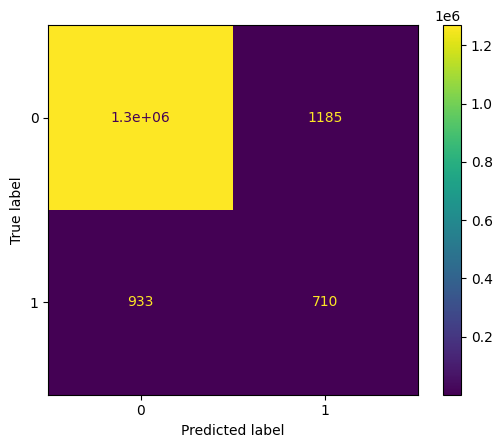

In [13]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(lr_model, x_test, y_test)

According to the confusion matrix, the model successfully predicts legitimate transactions approximately 13 million times, indicating a generally successful model. However, it incorrectly classifies about 933 fraud cases as legitimate transactions, which could cause customer dissatisfaction. To improve the model, it's essential to consider the type of transaction. The dataset documentation indicates a crucial link between fraud and transaction type, as fraud typically involves debiting the user's account through transfers and cash-outs. Therefore, incorporating the transaction type information is important for enhancing the model's performance.

Based on the dataset description, unauthorized transfers between accounts, where any single transaction exceeding 200,000 is considered illegal, can be flagged. This information can be used to create a new feature flag based on the transaction amount, which can then be utilized for inference.

In [14]:
data['isIllegal'] = data['amount'] > 200000

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder() #Convert categorical variables (type) into numeric values using label encoding or one-hot encoding.
data['type'] = label_encoder.fit_transform(data['type'])
data['']

In [19]:
#dividing dataset 
x = data.drop(['isIllegal','nameOrig','nameDest'], axis=1)
y = data['isIllegal']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [21]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

**Random Forest**
Standardization is used to address both regression (numerical target variable) and classification (categorical target variable) problems. Random Forest is an ensemble method, which means it combines predictions from multiple models. These smaller models are decision trees.

In [22]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [24]:
rf_model = model.fit(x_train, y_train)

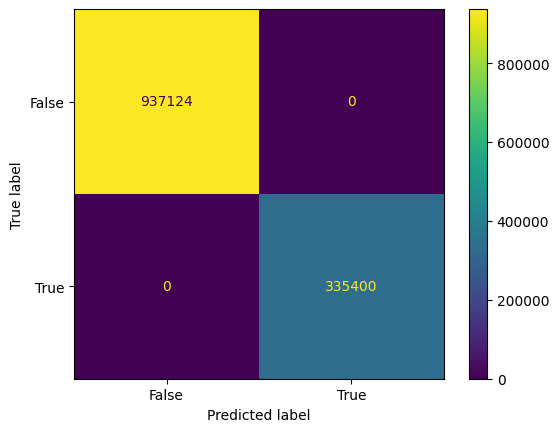

In [25]:
%matplotlib inline
_ = ConfusionMatrixDisplay.from_estimator(rf_model, x_test, y_test)

Clearly, using random forest model, it is able to accurately predict if the transaction is fraud or not. 

In the second approach, unsupervised learning is employed, where the model is trained on a dataset lacking labeled instances of fraud. Instead, the model learns from an unlabeled dataset of normal transactions, and then identifies outliers within this dataset, which are likely to represent fraudulent activities.

**Isolation Forest**
Similar to Random Forest, this approach is also an ensemble method. It aggregates predictions from multiple decision trees to identify anomalies. Unlike supervised learning, it doesn't rely on labeled data but instead learns and adapts as it processes the data.

In [27]:
from sklearn.ensemble import IsolationForest
model_isolationforest = IsolationForest(contamination=0.01, random_state=42)

In [28]:
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
x = data[features]

In [30]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [31]:
sf_model = model_isolationforest.fit(x_scaled)

The model will predict anomalies in the dataset.

In [32]:
data['anomaly'] = sf_model.predict(x_scaled)
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})  # 1 indicates anomaly


In [33]:
from sklearn.metrics import classification_report, confusion_matrix


In this scenario, the column "isIllegal" contains the true values, while the generated column "anomaly" represents the predicted values. To assess the accuracy of the predictions, we compare these two columns.

In [34]:
print(confusion_matrix(data['isIllegal'], data['anomaly']))
print(classification_report(data['isIllegal'], data['anomaly']))


[[4664063   24987]
 [1634930   38640]]
              precision    recall  f1-score   support

       False       0.74      0.99      0.85   4689050
        True       0.61      0.02      0.04   1673570

    accuracy                           0.74   6362620
   macro avg       0.67      0.51      0.45   6362620
weighted avg       0.71      0.74      0.64   6362620



The F1-score, which measures the accuracy of correct detection, stands at approximately 85%. This indicates that the model effectively predicts true positives in the majority of cases. To further enhance confidence in the model's performance, fine-tuning of hyperparameters can be considered in subsequent iterations.